# E-coli core Metabolism Analysis

## Contents

* Analysing the relationship between different carbon sources of the system and its biomass production.

Here, we analyse the E-coli core metabolism. We use we used is from the research of [Orth et al, 2010] (https://pubmed.ncbi.nlm.nih.gov/26443778/)and available in the [BiGG database](http://bigg.ucsd.edu/models/e_coli_core). You can find a graphical description of the model in this picture:

![network](data/Ecoli_core.png)
An overview of the core E coli metabolism The outer and the inner blue boxes represent
the outer and the inner surface of the cytoplasmic membrane Cytosolic metabolites are
represented by orange circles and the extracellular metabolites by yell circles Reaction
names are shown in blue.

## Loading Libraries and the Model

In [1]:
import cobra
import numpy as np
import matplotlib.pyplot as plt

# import the glycolysis model
model = cobra.io.read_sbml_model('data/e_coli_core.xml')

## Explore the model dimensions

We explore the external reactions and involved metabolites of the model, as well as the active reactions to obtain an overview.

In [31]:
# print("Reactions")
# print("name : id : reaction : lb : ub")
external_reactions = 0
external_metabolites = []
# only print external_reactions
for row in model.reactions:
    if row.id.startswith("EX_"):
        print(row.name, ":", row.id, ":", row.lower_bound, ":", row.upper_bound)
        external_reactions += 1
        for key in row.metabolites.keys():
            if row.metabolites[key] < 0:
                external_metabolites.append(key.name)
print("=================================================================")
print("External metaboites:", external_metabolites)
print("Number of external_reactions:", external_reactions)
print("==================================================================")
fluxes = model.optimize().fluxes
print("The active reactions are:")
print(list(fluxes[fluxes.round(3) == 0].index))

Acetate exchange : EX_ac_e : 0.0 : 1000.0
Acetaldehyde exchange : EX_acald_e : 0.0 : 1000.0
2-Oxoglutarate exchange : EX_akg_e : 0.0 : 1000.0
CO2 exchange : EX_co2_e : -1000.0 : 1000.0
Ethanol exchange : EX_etoh_e : 0.0 : 1000.0
Formate exchange : EX_for_e : 0.0 : 1000.0
D-Fructose exchange : EX_fru_e : 0.0 : 1000.0
Fumarate exchange : EX_fum_e : 0.0 : 1000.0
D-Glucose exchange : EX_glc__D_e : -10.0 : 1000.0
L-Glutamine exchange : EX_gln__L_e : 0.0 : 1000.0
L-Glutamate exchange : EX_glu__L_e : 0.0 : 1000.0
H+ exchange : EX_h_e : -1000.0 : 1000.0
H2O exchange : EX_h2o_e : -1000.0 : 1000.0
D-lactate exchange : EX_lac__D_e : 0.0 : 1000.0
L-Malate exchange : EX_mal__L_e : 0.0 : 1000.0
Ammonia exchange : EX_nh4_e : -1000.0 : 1000.0
O2 exchange : EX_o2_e : -20.0 : 1000.0
Phosphate exchange : EX_pi_e : -1000.0 : 1000.0
Pyruvate exchange : EX_pyr_e : 0.0 : 1000.0
Succinate exchange : EX_succ_e : 0.0 : 1000.0
External metaboites: ['Acetate', 'Acetaldehyde', '2-Oxoglutarate', 'CO2', 'Ethanol', '

## Relationship of Glucose uptake, Biomass production and fluxes

To find the relationship of glucose uptake with biomass production, we perform FBA with different uptake rates of glucose. We find that glucose is a nutrient that act growth limiting, as it linearly correlates with biomass production. Furthermore biomass production is zero when glucose uptake is zero.

C:\Users\paesc\anaconda3\envs\cobra_env\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Text(0, 0.5, 'Biomass production [mmol/gDW/hr]')

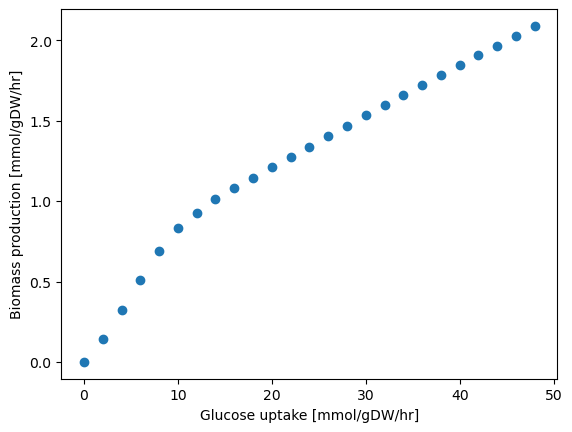

In [37]:
# extract the reaction id for D-Glucose exchange
for i in model.reactions:
    if i.name == "D-Glucose exchange": ID = i.id
# lower bound controls the productions of the negative values (keys) in metabolite dictionary (educts), if zero it cannot be taken up
# but if negative it can be produced...
# upper bound control the productions fo the positive (it is positive, things can always leave the system) (product)
uptake = np.arange(0, -50, -2)
opts = []
for l in uptake:
    model.reactions.get_by_id(ID).lower_bound = l # this sets the productions
    fba_solution = model.optimize()
    #print(fba_solution.objective_value)
    #print(model.summary())
    opts.append(fba_solution.objective_value)

plt.scatter(-uptake, opts)
plt.xlabel("Glucose uptake [mmol/gDW/hr]")
plt.ylabel("Biomass production [mmol/gDW/hr]")

Let's take a closer look to understand what happens when the glucose uptake changes. To explore this, we perform FBA for different glucose uptake values between 0 and 50 mmol/gDW/hr. We store the flux value of the external reactions with the IDs EX_o2_e (02 Exchange, EX_co2_e (CO2 Exchange), EX_ac_e (Actetate Exchange and EX_etoh_e (Ethanol Exchange) to finally plot them along each other.

C:\Users\paesc\anaconda3\envs\cobra_env\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


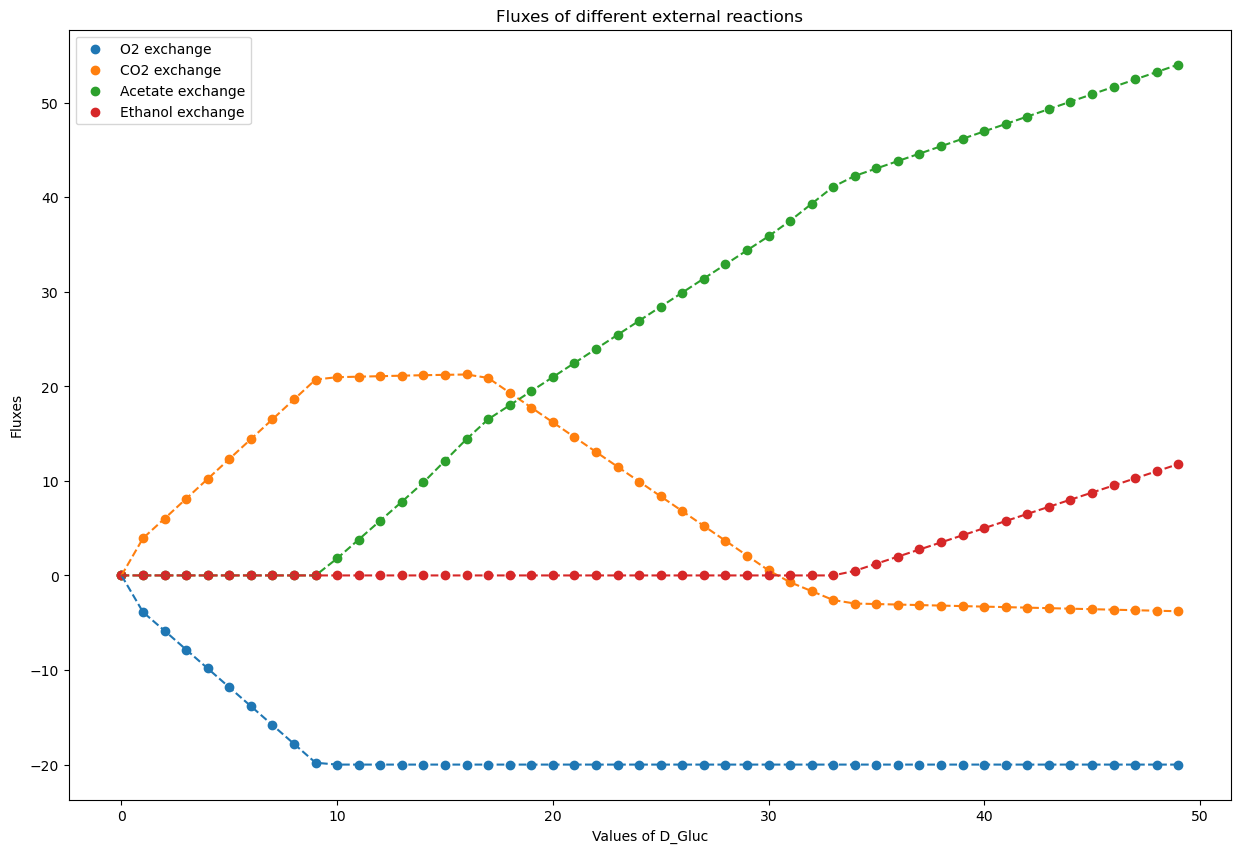

In [40]:
# reimport the model as we changed glucose uptake
model = cobra.io.read_sbml_model('data/e_coli_core.xml')

# extract the reaction id for D-Glucose exchange
for i in model.reactions:
    if i.name == "D-Glucose exchange": ID = i.id

uptake = np.arange(0, -50, -1)
opts = {"EX_o2_e": [], "EX_co2_e":[], "EX_ac_e": [], "EX_etoh_e":[]}
for l in uptake:
    model.reactions.get_by_id(ID).lower_bound = l
    fba_solution = model.optimize()
    for key in opts.keys():
        fluxes = fba_solution.fluxes
        mask = fluxes.index == key
        opts[key].append(fluxes[mask][0])

# plot all the keys
plt.figure(figsize = (15, 10))
for key in opts:
    plt.scatter(-uptake, opts[key], label = model.reactions.get_by_id(key).name)
    plt.plot(-uptake, opts[key], linestyle ="dashed")

plt.xlabel("Values of D_Gluc")
plt.ylabel("Fluxes")
plt.title("Fluxes of different external reactions")
plt.legend()

Depending on different uptakes of glucose, we see that there are different pathways of biomass production as the substrate exchange of the system varies.

## Acetate as the sole carbon source

Next, we compute the biomass growth rate for acetate as the sole carbon source with an acetate uptake flux of 10 mmol/gDW/hr. We try to found out whether this situation is different from having glucose as the sole carbon source.

In [47]:
# list to store optima
optima = []
# define the lower bound of 10 mmol/gDW/hr
lb = -10
# reimport the model
model = cobra.io.read_sbml_model('data/e_coli_core.xml')
# set all other externals to zero IF THEY CONTAIN CARBON, only actetate to -10
for row in model.exchanges:
    if row.name == "Acetate exchange":
        ID = row.id
        # row.lower_bound = lb
    # set all that contain carbon to zero!
    else:
        for met in row.metabolites:
            if "C" in met.elements.keys():
                row.lower_bound = 0

print("Acetate biomass production summary:")
# setback
model.reactions.get_by_id(ID).lower_bound = lb
fba_solution = model.optimize()
optima.append(fba_solution.objective_value)
print(model.summary())
print("======================================")
# import the model again and repeat procedure
model = cobra.io.read_sbml_model('e_coli_core.xml')
# set all other externals to zero IF THEY CONTAIN CARBON, only actetate to -10
for row in model.exchanges:
    if row.name == "D-Glucose exchange":
        ID = row.id
    # we set all that contain carbon to zero!
    else:
        for met in row.metabolites:
            if "C" in met.elements.keys():
                row.lower_bound = 0

print("Glucose biomass production summary:")
model.reactions.get_by_id(ID).lower_bound = lb
fba_solution = model.optimize()
optima.append(fba_solution.objective_value)
print(model.summary())

Acetate biomass production summary:
Objective
1.0 BIOMASS_Ecoli_core_w_GAM = 0.1733385844777864

Uptake
------
Metabolite Reaction   Flux  C-Number  C-Flux
      ac_e  EX_ac_e     10         2 100.00%
       h_e   EX_h_e  6.523         0   0.00%
     nh4_e EX_nh4_e 0.9452         0   0.00%
      o2_e  EX_o2_e  12.42         0   0.00%
      pi_e  EX_pi_e 0.6377         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -12.62         1 100.00%
     h2o_e EX_h2o_e -13.89         0   0.00%

Glucose biomass production summary:
Objective
1.0 BIOMASS_Ecoli_core_w_GAM = 0.8326136426821369

Uptake
------
Metabolite    Reaction  Flux  C-Number  C-Flux
  glc__D_e EX_glc__D_e    10         6 100.00%
     nh4_e    EX_nh4_e  4.54         0   0.00%
      o2_e     EX_o2_e    20         0   0.00%
      pi_e     EX_pi_e 3.063         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number C-Flux
      ac_e  EX_ac_e -1.803         2 14.67%
     co

<BarContainer object of 2 artists>

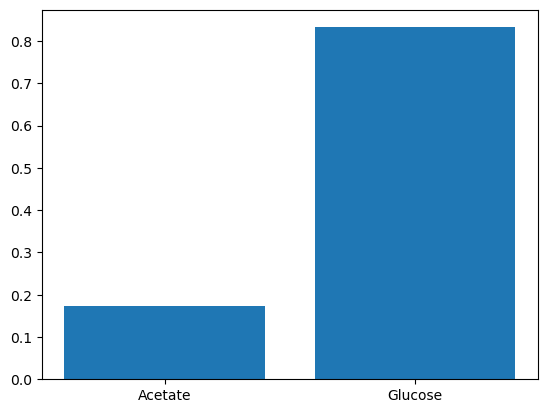

In [49]:
plt.bar(["Acetate", "Glucose", ], optima)

We find that the Biomass production with uptake rate 10 mmol/gDW/hr of carbon source is much higher if glucose is the sole carbon source. We can explain this by taking at the model summaries. Glucose contain 6 C-atoms, while Acetate only has 2, meaning that per mmol of glucose the system is provided with more C-atoms!

## Other carbon sources

In this section we try to find other metabolites that could be used as carbon sources for the core metabolism of E. coli. For a metabolite to be a potential carbon source, it must be able to be imported into the cell and must possess at least one carbon atom. The first condition is met by all metabolites with an associated external reaction. Checking if a given metabolite possesses at least one carbon atom can be done by assesing `metabolite.elements`.

In [50]:
lb = -10
# import the glycolysis model
model = cobra.io.read_sbml_model('data/e_coli_core.xml')
carbon_sources = []
for met in model.metabolites:
    if ("C" in met.elements.keys() and met.compartment == "e"):
        carbon_sources.append(met.name)

print("Carbon sources:", carbon_sources)
print("\nNumber of carbon_sources:", len(carbon_sources))

Carbon sources: ['Acetate', 'Acetaldehyde', '2-Oxoglutarate', 'CO2', 'Ethanol', 'Formate', 'D-Fructose', 'Fumarate', 'D-Glucose', 'L-Glutamine', 'L-Glutamate', 'D-Lactate', 'L-Malate', 'Pyruvate', 'Succinate']
Number of carbon_sources: 15


Thank you for checking out this quick analysis of the E coli core network!